# Racetrack Coil Design

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
import random
import magpylib as magpy
import nbimporter
#%matplotlib notebook

Requirements:
Recall that cell is 10x20x80 mm.

In [151]:
# I'll approximate the "racetrack" as a square. 
# The minimum length and width should be set here.
# I want the enclosure to be a square prism.

cell_x = 10 #mm
cell_y = 20 #mm
cell_z = 80 #mm

# 16 gauge wire
copper_diam = 1.29032 #mm
insulator_thickness = 0.5 #mm (ADJUST)
total_wire_diam = copper_diam + insulator_thickness

# Enclosure boundaries
view_gap = 20 #mm (ADJUST)
enc_length = cell_z + view_gap
enc_width = cell_y + view_gap

# Collection building:
collection = magpy.Collection()

# Build cell:
cell = magpy.magnet.Cuboid(magnetization=(0,0,0), dimension=(cell_x, cell_y, cell_z), 
                           style={'color':"lightblue", 'opacity':0.25})
collection.add(cell)

# Build enclosure
enclosure = magpy.magnet.Cuboid(magnetization=(0,0,0), dimension=(enc_width, enc_width, enc_length), 
                           style={'color':"black", 'opacity':0.1})
collection.add(enclosure)

# Build a coil:
num_layers = 6
num_in_layer = 8
coil_current = 3.7 # in Amps
total_length = 0
for i in range(0, num_layers):
    for j in range(0, num_in_layer):
        # The layer determines the width and length.
        length = enc_length + j*total_wire_diam
        width = enc_width + j*total_wire_diam
        
        # Keep track of the total_length of the coil
        total_length += 2*length + 2*width
        
        
        # Where is the center of the loop? We should put it half the enclosure width away from the origin, then
        # leave space for the wire diameter, and then increment it by a wire-diameter for each wire
        # we want to add in the layer. This is why there is a (i+1) and not just i.
        mid_position = (enc_width)/2+(i+1)*total_wire_diam
        # Build the vertices of the wire.
        vertices = [(mid_position, width/2, -length/2), (mid_position, width/2, length/2), 
                    (mid_position, -width/2, length/2), (mid_position, -width/2, -length/2), 
                    (mid_position, width/2, -length/2)]
        # Coil on x = pos plane.
        coil1 = magpy.current.Line(coil_current, vertices=vertices)
        collection.add(coil1)
        
        # Next coil (coil on y = pos plane).
        coil2 = magpy.current.Line(-coil_current, vertices=vertices)
        coil2.rotate_from_angax(90, axis='z')
        collection.add(coil2)
        
        # Next coil (coil on x = neg plane)
        coil3 = magpy.current.Line(coil_current, vertices=vertices)
        coil3.rotate_from_angax(180, axis='z')
        collection.add(coil3)
        
        # Next coil (coil on x = neg plane)
        coil4 = magpy.current.Line(-coil_current, vertices=vertices)
        coil4.rotate_from_angax(270, axis='z')
        collection.add(coil4)
        
# Using the total_length of the coil, compute power dissipation.
print(round(total_length/1000, 3), "meters of coil")
rho = 1.7 * 10**(-8) # Ohm-meter, Copper resistivity
Power = (coil_current)**2 * rho * ((total_length/1000)/(np.pi * ((copper_diam/1000)/2)**2))
print("Power dissipated =", Power, " W")

14.643 meters of coil
Power dissipated = 2.6061566193489067  W


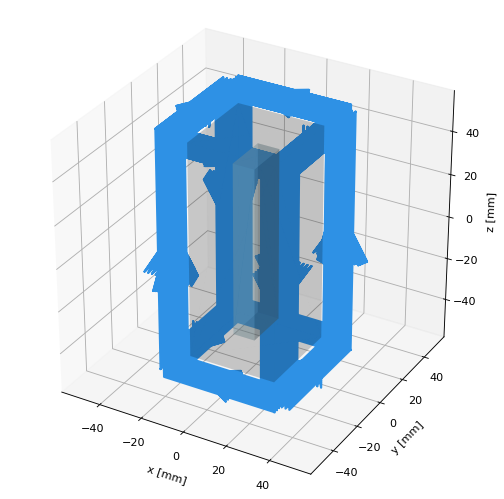

In [132]:
collection.show()

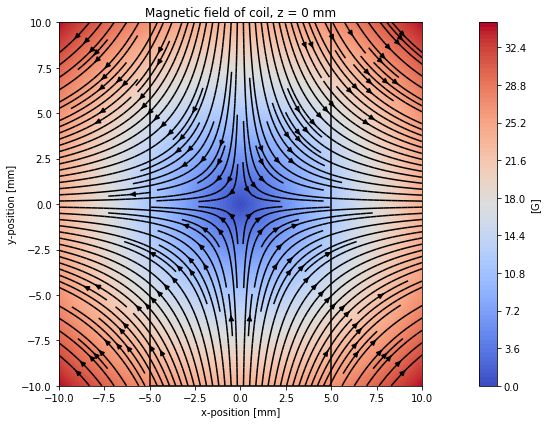

In [142]:
def plot_mag_field_xy(coil1, z=0):
    fig, axs = plt.subplots(1, 1, figsize=(16,6))
    
    # create grid
    xts = np.linspace(-cell_y/2, cell_y/2, 100)
    yts = np.linspace(-cell_y/2, cell_y/2, 100)
    grid = np.array([[(x,y,z) for x in xts] for y in yts])
    
    # compute and plot field of coil2
    B = magpy.getB(coil1, grid)
    Bamp = np.linalg.norm(B, axis=2) * 10
    
    cp = axs.contourf(
        grid[:,:,0], grid[:,:,1], Bamp,
        levels=100,
        cmap='coolwarm',
    )
    axs.streamplot(
        grid[:,:,0], grid[:,:,1], B[:,:,0], B[:,:,1],
        density=2,
        color='black',
    )
    axs.set(
        title='Magnetic field of coil, z = '+str(z)+" mm",
        xlabel='x-position [mm]',
        ylabel='y-position [mm]',
        aspect=1,
    )
    plt.colorbar(cp, ax=axs, label='[G]')
    plt.tight_layout()
    
    
    # Plotting cell on heatmap:
    plt.plot([-cell_x/2, cell_x/2], [cell_y/2, cell_y/2], '-k')
    plt.plot([-cell_x/2, cell_x/2], [-cell_y/2, -cell_y/2], '-k')
    plt.plot([cell_x/2, cell_x/2], [cell_y/2, -cell_y/2], '-k')
    plt.plot([-cell_x/2, -cell_x/2], [cell_y/2, -cell_y/2], '-k')
    
    
    plt.show()

plot_mag_field_xy(collection, z=0)

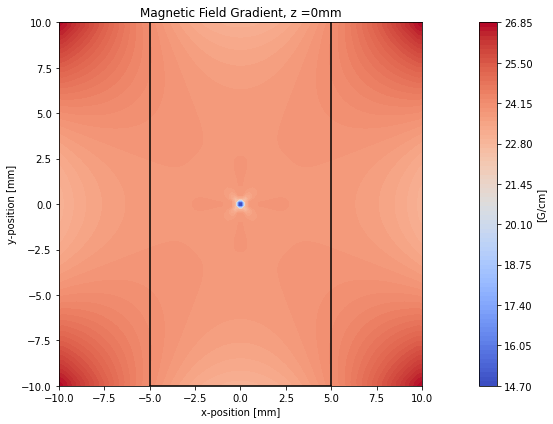

In [144]:
def plot_grad_xy(coil1, z):
    fig, axs = plt.subplots(1, 1, figsize=(16,6))
    
    # create grid
    xts = np.linspace(-cell_y/2, cell_y/2, 100)
    yts = np.linspace(-cell_y/2, cell_y/2, 100)
    grid = np.array([[(x,y,z) for x in xts] for y in yts])
    
    # compute and plot field of coil2
    B = magpy.getB(coil1, grid)
    Bamp = np.linalg.norm(B, axis=2) * 10 # mG -> G via the *10.
    
    cp = axs.contourf(
        grid[:,:,0], grid[:,:,1], np.linalg.norm(np.gradient(Bamp, xts[1]-xts[0]),axis=0) * 10,
        levels=100,
        cmap='coolwarm',
    )
    
    axs.set(
        title='Magnetic Field Gradient, z ='+str(z)+ "mm",
        xlabel='x-position [mm]',
        ylabel='y-position [mm]',
        aspect=1,
    )
    plt.colorbar(cp, ax=axs, label='[G/cm]')
    plt.tight_layout()
    
    # Plotting cell on heatmap:
    plt.plot([-cell_x/2, cell_x/2], [cell_y/2, cell_y/2], '-k')
    plt.plot([-cell_x/2, cell_x/2], [-cell_y/2, -cell_y/2], '-k')
    plt.plot([cell_x/2, cell_x/2], [cell_y/2, -cell_y/2], '-k')
    plt.plot([-cell_x/2, -cell_x/2], [cell_y/2, -cell_y/2], '-k')
    
    
    
    plt.show()
    
plot_grad_xy(collection, z=0)

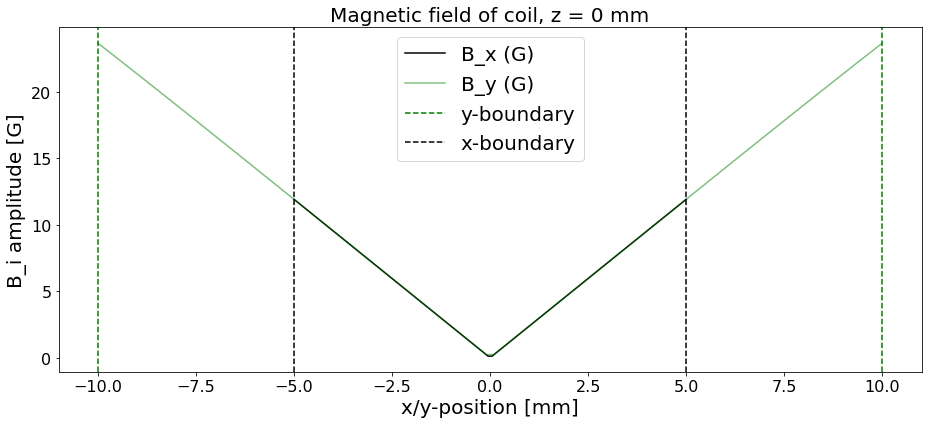

In [145]:
def plot_mag_amp_line(coil1,z):
    fig, ax = plt.subplots(1, 1, figsize=(13,6))
    xts = np.linspace(-cell_x/2, cell_x/2, 100)
    grid = np.array([(x,0,z) for x in xts])
    # compute and plot field of coil2
    B = magpy.getB(coil1, grid)
    Bamp = np.linalg.norm(B, axis=1) * 10 # in Gauss
    ax.plot(grid[:,0],Bamp, label="B_x (G)", c="k")
    ax.set_title('Magnetic field of coil, z = '+str(z)+" mm", fontsize=20)
    ax.set_xlabel('x/y-position [mm]', fontsize=20)
    ax.set_ylabel('B_i amplitude [G]', fontsize=20)
    ax.tick_params('both', labelsize=16)
    
    yts = np.linspace(-cell_y/2, cell_y/2, 100)
    grid = np.array([(0,y,z) for y in yts])
    # compute and plot field of coil2
    B = magpy.getB(coil1, grid)
    Bamp = np.linalg.norm(B, axis=1) * 10 # in Gauss
    ax.plot(grid[:,1],Bamp, label="B_y (G)", c="g", ls="-", alpha=0.5)

    
    plt.axvline(-cell_y/2, label="y-boundary", c="g", ls="--")
    plt.axvline(cell_y/2, c="g", ls="--")
    
    plt.axvline(-cell_x/2, label="x-boundary", c="k", ls="--")
    plt.axvline(cell_x/2, c="k", ls="--")
    
    plt.tight_layout()
    plt.legend(fontsize=20)
    plt.show()
    
plot_mag_amp_line(collection, z=0)